# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import math
import pathlib
import re

In [2]:
# Color style similar to ppt color scheme
plt.style.use('seaborn-colorblind')

#Latex Default Font
plt.rc('font', family='serif') 
plt.rc('font', serif='Latin Modern Roman')
matplotlib.rcParams.update({'font.size': 16})

In [3]:
def make_hatches(ax, df):
    hatches = [h*len(df.index) for h in [['//'], ['--'], ['x'], ['\\'], ['||'], ['+'], ['o'], ['.']]]
    hatches = sum(hatches, [])

    if len(hatches) < len(ax.patches):
        print("Not enough hatches defined")
        
    for i,bar in enumerate(ax.patches):
        bar.set_hatch(hatches[i])
    ax.legend()

# Constants 

In [4]:
# Frequency of rocketchip (in GHz)
rocketFreq = 3.2

## Load Raw Results

In [5]:
def combine(srcDir):
    df = None
    for srcF in srcDir.glob("*.csv"):
        llPat = re.compile("(.*)_pflat_(\d*)")
        match = llPat.match(str(srcF.stem))
        ll = float(match.group(2))
        exp = match.group(1)
        name = exp + str(int(ll))
        newDf = pd.read_csv(srcF, header=0, comment="#")
        
        # Note that the switch is configured for a 10 cycle delay, link latency is a single hop
        newDf['rtt'] = ll*4 + 10
        
        # Convert to ns
        newDf = (newDf / rocketFreq)
        
        newDf['config'] = exp
        newDf.rename({0 : name}, inplace=True)
        
        if df is None:
            df = newDf
        else:
            df = df.append(newDf)
            
    return df
        
    
results = combine(pathlib.Path("./exampleResults"))
print(results)

         t_rmem_read   t_fault          trap     e2e  t_rmem_read_raw  \
sw1610       2748.75  7673.750  1.650000e+02  7992.5        2808.4375   
pfa1610         0.00  1579.375 -2.094380e+09  2570.0        2815.9375   

              rtt config  
sw1610   2015.625     sw  
pfa1610  2015.625    pfa  


In [6]:
def cleanPFA(ser):
    clean = {}
    # Can't measure trap in PFA (maybe with some hardware instrumentation)
    clean['Trap'] = 0
    # 1 cycle PFA overhead (from source inspection)
    clean['Local Processing'] = 1
    clean['NW Link'] = ser['rtt']
    # Technically this includes trap overheads as well (TLB miss, PT walk, etc.)
    clean['RDMA Overhead'] = ser['e2e'] - ser['rtt'] - clean['Trap']
    
    return pd.Series(clean)

def cleanSW(ser):
    # SW has more complete info because we can instrument directly.
    # RDMA overhead includes SW drivers which add some time vs PFA
    clean = {}
    clean['Trap'] = ser['trap']
    clean['NW Link'] = ser['rtt']
    clean['RDMA Overhead'] = ser['t_rmem_read'] - ser['rtt']
    clean['Local Processing'] = ser['e2e'] - clean['Trap'] - clean['NW Link'] - clean['RDMA Overhead']
    
    return pd.Series(clean)

fastNW = pd.DataFrame({"APF" : cleanPFA(results.loc['pfa1610', :])})
fastNW['SW'] = cleanSW(results.loc['sw1610', :])
fastNW = fastNW.transpose()

fastNW

,Trap,Local Processing,NW Link,RDMA Overhead
APF,0.0,1.00,2015.625,554.375
SW,165.0,5078.75,2015.625,733.125


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


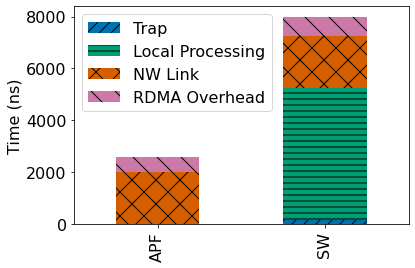

In [7]:
ax = fastNW.plot(kind="bar", stacked=True)
ax.set_ylabel("Time (ns)")
make_hatches(ax, fastNW)
ax.get_figure().savefig("apfBreakdown500ns.pdf", bbox_inches = "tight", format="pdf")